In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# change the path to the location of the data files
# Read a CSV file into a DataFrame
applicants_1st = pd.read_csv('../raw_data/1stBatch_Applicants.csv')
entrance_scores_1st = pd.read_csv('../raw_data/1stBatch_Entrance_Score.csv')
student_data_1st = pd.read_csv('../raw_data/1stBatch_Stduentdata.csv')
original_1st = pd.read_csv('../raw_data/GED_1st batch Data_Original.csv')


original_1st = original_1st.dropna(how='all')  # This will drop rows where all elements are NaN or missing.

# rename the columns of original_1st
original_1st.columns = ['Student ID', 'Gender', 'Age', 'Location', 'Highest Education','Specilization in High School', 'Current Job/School']


# Merge the datasets on 'Student ID', prioritizing the columns from original_1st
applicants_1st = pd.merge(applicants_1st, original_1st[['Student ID', 'Gender','Specilization in High School', 'Current Job/School']], 
                       on='Student ID', how='inner', suffixes=('_applicants', '_original'))

# Replace "Specilization in High School" and "Current Job/School" in applicants_1st with those from original_1st
applicants_1st['Specilization in High School'] = applicants_1st['Specilization in High School_original']
applicants_1st['Current Job/School'] = applicants_1st['Current Job/School_original']

# Drop the redundant columns
applicants_1st.drop(columns=['Entranced','Specilization in High School_applicants', 'Specilization in High School_original', 
                          'Current Job/School_applicants', 'Current Job/School_original'], inplace=True)

# print(applicants_1st)

In [11]:
# Clean column names by removing extra spaces
applicants_1st.columns = applicants_1st.columns.str.strip()
entrance_scores_1st.columns = entrance_scores_1st.columns.str.strip()
student_data_1st.columns = student_data_1st.columns.str.strip()

# Rename 'Unnamed: 0' to 'Student ID' 
entrance_scores_1st.rename(columns={'Unnamed: 0': 'Student ID'}, inplace=True)

# Rename 'Sr.No' to 'Student ID'
student_data_1st.rename(columns={'Sr.No': 'Student ID'}, inplace=True)

# Identify the row index where the second occurrence of '3' appears (between 23 and 25)
second_3_index = applicants_1st[(applicants_1st['Student ID'] == 3) & (applicants_1st.index > 22)].index[0]
# Change the value in the identified row
applicants_1st.at[second_3_index, 'Student ID'] = 24


# Find the index of the second occurrence of '28'
indices_applicant = applicants_1st[applicants_1st['Student ID'] == 28].index
indices_entrance = entrance_scores_1st[entrance_scores_1st['Student ID'] == 28].index

# If there is a second occurrence, update it to 30
if len(indices_applicant) > 1:
    applicants_1st.at[indices_applicant[1], 'Student ID'] = 30

if len(indices_entrance) > 1:
    entrance_scores_1st.at[indices_entrance[1], 'Student ID'] = 30

applicants_1st = applicants_1st.drop_duplicates()
entrance_scores_1st = entrance_scores_1st.drop_duplicates()
student_data_1st = student_data_1st.drop_duplicates()

In [12]:
# Identify the problematic rows manually
print(applicants_1st[['Age']].loc[[37, 38, 39, 40, 41]])  # Check the specific rows

# # Manually correct the values
applicants_1st.loc[37, 'Age'] = 2024 - 1998  # Convert '1/1/1998' to age
applicants_1st.loc[38, 'Age'] = 2024 - 2000  # Convert '2000' to age
applicants_1st.loc[40, 'Age'] = 15  # convert 15 yrs to 15

# Optional: Verify the corrections
print(applicants_1st[['Age']].loc[[37, 38, 39, 40, 41]])


         Age
37  1/1/1998
38      2000
39        20
40    15 yrs
41        19
   Age
37  26
38  24
39  20
40  15
41  19


In [13]:
# Join the three tables using 'Student ID' as the key
batch1_combined = pd.merge(applicants_1st, entrance_scores_1st, on='Student ID', how='inner')
batch1_combined = pd.merge(batch1_combined, student_data_1st, on='Student ID', suffixes=('', '_studentdata'), how='inner')

# If both 'Name' columns exist, merge them into one 'Name' column
if 'Name' in batch1_combined.columns and 'Name_studentdata' in batch1_combined.columns:
    batch1_combined['Name'] = batch1_combined['Name'].combine_first(batch1_combined['Name_studentdata'])
    batch1_combined = batch1_combined.drop(columns=['Name_studentdata'])

# Handle missing values
batch1_combined['Math'] = batch1_combined['Math'].fillna('Unknown')

# Step 1: Define a function to categorize commitment
def categorize_commitment(remark):
    if remark == 'Drop':
        return 'Low'  # 'Drop' indicates low commitment
    else:
        return 'High'  # All other remarks indicate high commitment

# Step 2: Create a new 'Commitment' column
batch1_combined['Commitment'] = batch1_combined['Remark'].apply(categorize_commitment)

# Reordering columns so that 'GED -ID' and 'Name' are between 'Student ID' and 'Age'
reordered_columns = ['Student ID', 'GED -ID', 'Name', 'Age', 'Gender'] + [col for col in batch1_combined.columns if col not in ['Student ID', 'GED -ID', 'Name', 'Age','Gender']]
batch1_combined = batch1_combined[reordered_columns]

# sort the data by 'GED -ID' in ascending order
batch1_combined = batch1_combined.sort_values(by='GED -ID', ascending=True)

# Define the Student IDs for each category
student_ids = [6, 41, 9, 22, 23, 28]
job_ids = [26, 17, 12]  # Example IDs with jobs; modify based on actual data

# Add a new column with default value as 'unknown'
batch1_combined['Socio-economic background'] = 'unknown'

# Set "student" for specific Student IDs
batch1_combined.loc[batch1_combined['Student ID'].isin(student_ids), 'Socio-economic background'] = 'student'

# Set "job" for specific Student IDs
batch1_combined.loc[batch1_combined['Student ID'].isin(job_ids), 'Socio-economic background'] = 'job'

In [14]:
print(batch1_combined)

    Student ID     GED -ID                  Name Age  Gender  \
0            6  GED2024001       Aung Khant Hein  22    Male   
4           19  GED2024002         Khant Nyi Zin  16    Male   
9           26  GED2024003        Shwe Yee Phyoe  19  Female   
13          41  GED2024004      Myat Ko Ko Khant  15    Male   
1            9  GED2024006        Kyal Sin Thwel  16  Female   
3           17  GED2024007  Aye Mon Yadanar Aung  18  Female   
5           22  GED2024008        Myat Htoo Kyaw  17    Male   
11          29  GED2024009       Htun Pa Pa Linn  17  Female   
12          32  GED2024010           Moh Moh Win  19  Female   
6           23  GED2024012          Than Cynn Oo  16  Female   
7           24  GED2024013              Nann Oak  19  Female   
10          28  GED2024014            Sa SannLin  18    Male   
14          46  GED2024017          Pun Khattgar  17  Female   
8           25  GED2024018         Kyal Sin Thaw  17  Female   
2           12  GED2024019   Kyaw Myo Th

In [15]:
# change 1st batch combined data to csv file
# batch1_combined.to_csv('../combined_and_clean_data/1stBatch_Combined.csv', index=False)

# 1. Get an overview of the demographic composition for Batch 1

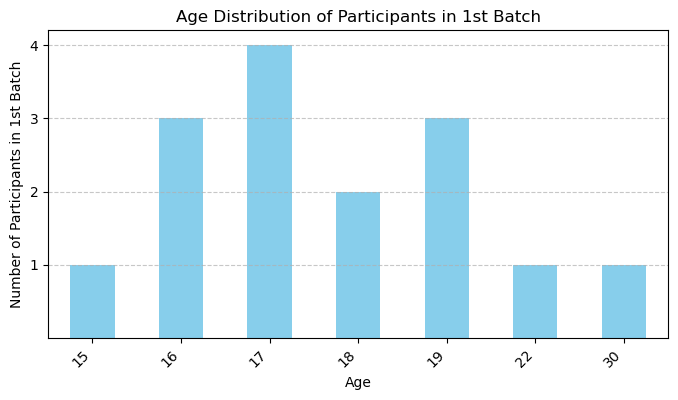

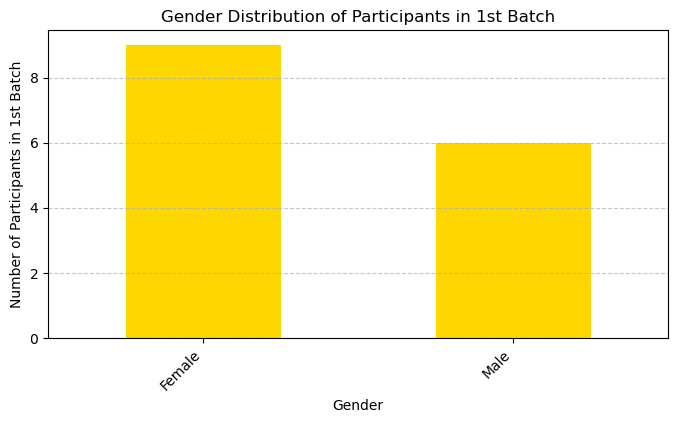

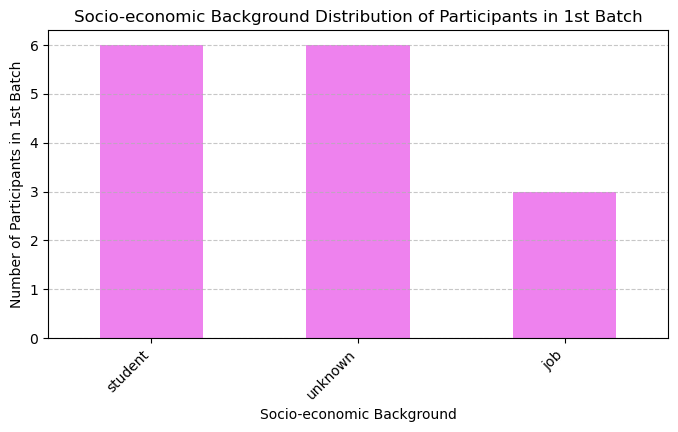

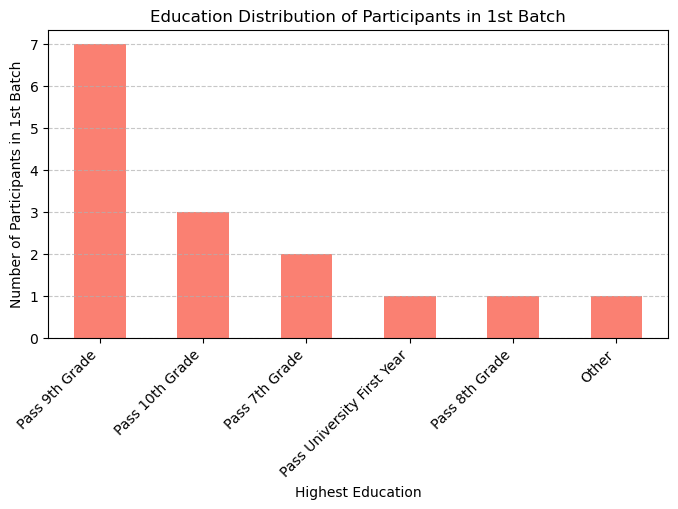

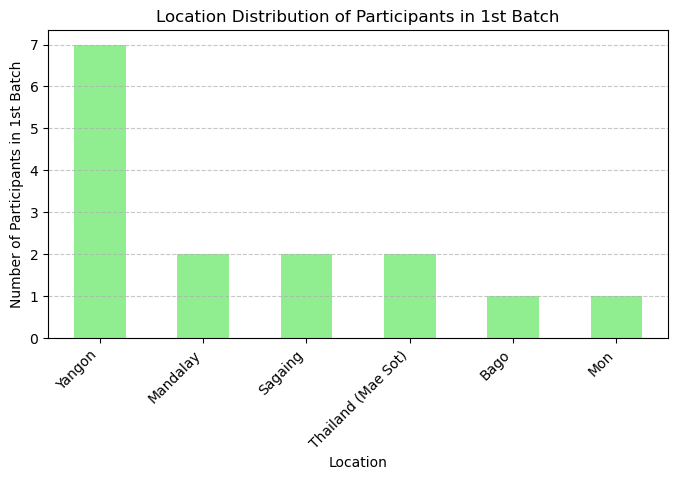

In [16]:

# 1. Plot Age Distribution
# Convert 'Age' column to numeric, forcing errors to NaN and filling with a default value (if needed)
batch1_combined['Age'] = pd.to_numeric(batch1_combined['Age'], errors='coerce').fillna(0).astype(int)

# 1. Plot Age Distribution
plt.figure(figsize=(8, 4))
batch1_combined['Age'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Age Distribution of Participants in 1st Batch')
plt.xlabel('Age')
plt.ylabel('Number of Participants in 1st Batch')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for readability
plt.yticks([1, 2, 3, 4])  # Show only whole numbers on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Plot Gender Distribution
plt.figure(figsize=(8, 4))
batch1_combined['Gender'].value_counts().plot(kind='bar', color='gold')
plt.title('Gender Distribution of Participants in 1st Batch')
plt.xlabel('Gender')
plt.ylabel('Number of Participants in 1st Batch')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Plot Background Distribution
plt.figure(figsize=(8, 4))
batch1_combined['Socio-economic background'].value_counts().plot(kind='bar', color='violet')
plt.title('Socio-economic Background Distribution of Participants in 1st Batch')
plt.xlabel('Socio-economic Background')
plt.ylabel('Number of Participants in 1st Batch')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4. Plot Education Distribution
plt.figure(figsize=(8, 4))
batch1_combined['Highest Education'].value_counts().plot(kind='bar', color='salmon')
plt.title('Education Distribution of Participants in 1st Batch')
plt.xlabel('Highest Education')
plt.ylabel('Number of Participants in 1st Batch')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 5. Plot Location Distribution
plt.figure(figsize=(8, 4))
batch1_combined['Location'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Location Distribution of Participants in 1st Batch')
plt.xlabel('Location')
plt.ylabel('Number of Participants in 1st Batch')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:

selected_columns = batch1_combined[['Student ID', 'Age', 'Location', 'Highest Education','Remark']]
print(selected_columns)

    Student ID  Age            Location           Highest Education  \
0            6   22            Mandalay  Pass University First Year   
4           19   16            Mandalay              Pass 7th Grade   
9           26   19             Sagaing             Pass 10th Grade   
13          41   15             Sagaing              Pass 7th Grade   
1            9   16              Yangon              Pass 8th Grade   
3           17   18              Yangon             Pass 10th Grade   
5           22   17              Yangon              Pass 9th Grade   
11          29   17                Bago              Pass 9th Grade   
12          32   19              Yangon              Pass 9th Grade   
6           23   16  Thailand (Mae Sot)              Pass 9th Grade   
7           24   19              Yangon             Pass 10th Grade   
10          28   18              Yangon              Pass 9th Grade   
14          46   17              Yangon              Pass 9th Grade   
8     

# 2. Commitment and engagement for batch 1

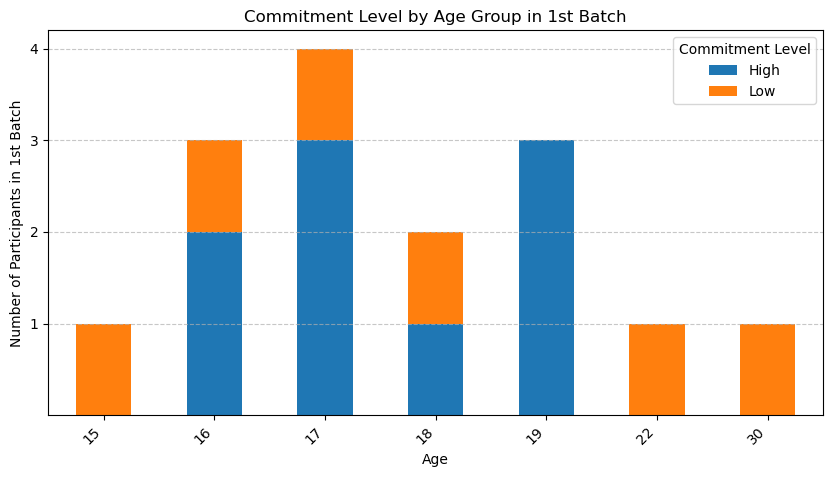

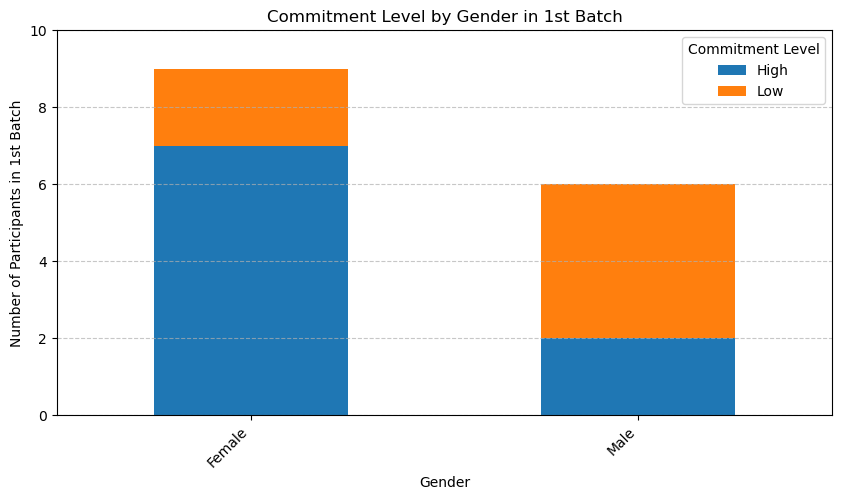

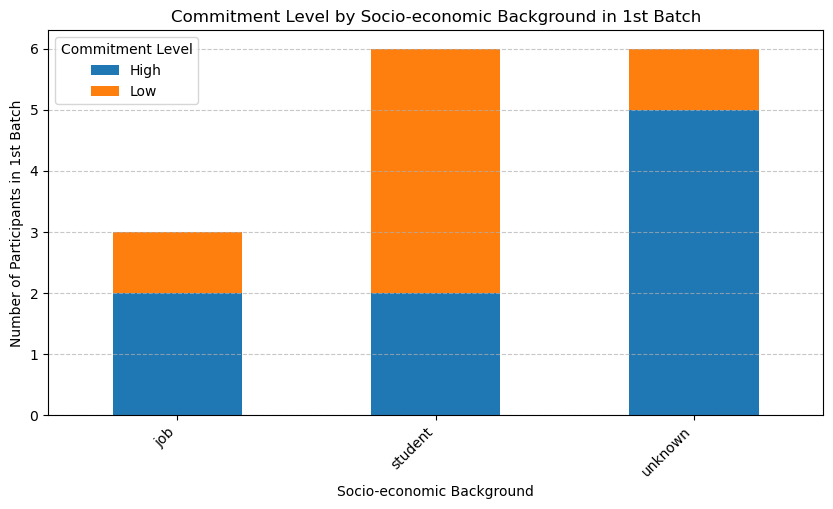

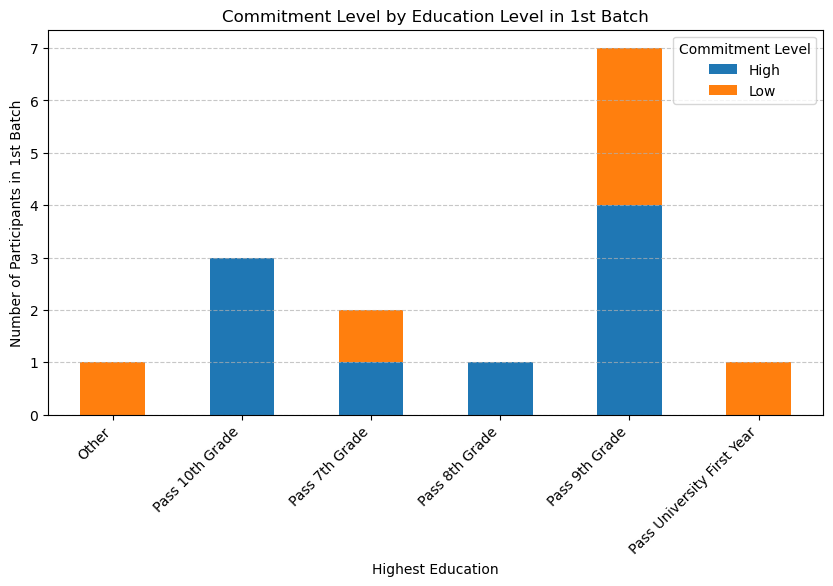

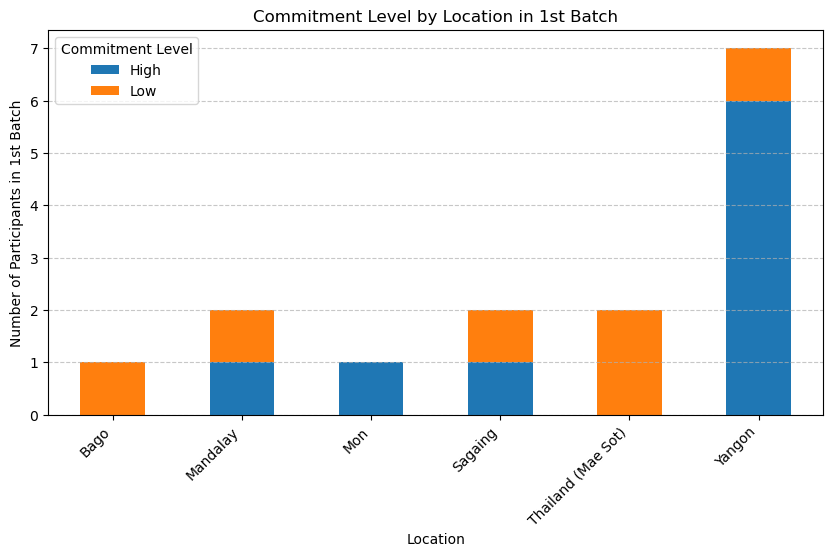

In [18]:
# 1. Analyze Commitment by Age Group
commitment_by_age = batch1_combined.groupby('Age')['Commitment'].value_counts().unstack().fillna(0)
commitment_by_age.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('Commitment Level by Age Group in 1st Batch')
plt.xlabel('Age')
plt.ylabel('Number of Participants in 1st Batch')
plt.xticks(rotation=45, ha='right')
plt.yticks([1, 2, 3, 4])  # Show only whole numbers on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Commitment Level')
plt.show()

# 2. Analyze Commitment by Gender
commitment_by_gender = batch1_combined.groupby('Gender')['Commitment'].value_counts().unstack().fillna(0)
commitment_by_gender.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('Commitment Level by Gender in 1st Batch')
plt.xlabel('Gender')
plt.ylabel('Number of Participants in 1st Batch')
plt.xticks(rotation=45, ha='right')
plt.yticks([0, 2, 4, 6, 8, 10])  # Show only whole numbers on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Commitment Level')
plt.show()

# 3. Analyze Commitment by Socio-economic Background
commitment_by_background = batch1_combined.groupby('Socio-economic background')['Commitment'].value_counts().unstack().fillna(0)
commitment_by_background.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('Commitment Level by Socio-economic Background in 1st Batch')
plt.xlabel('Socio-economic Background')
plt.ylabel('Number of Participants in 1st Batch')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Commitment Level')
plt.show()

# 4. Analyze Commitment by Highest Education Level
commitment_by_education = batch1_combined.groupby('Highest Education')['Commitment'].value_counts().unstack().fillna(0)
commitment_by_education.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('Commitment Level by Education Level in 1st Batch')
plt.xlabel('Highest Education')
plt.ylabel('Number of Participants in 1st Batch')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Commitment Level')
plt.show()

# 5. Analyze Commitment by Location
commitment_by_location = batch1_combined.groupby('Location')['Commitment'].value_counts().unstack().fillna(0)
commitment_by_location.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('Commitment Level by Location in 1st Batch')
plt.xlabel('Location')
plt.ylabel('Number of Participants in 1st Batch')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Commitment Level')
plt.show()

###